# Path Finding with Z3
This notebook demonstrates using a solver like Z3 to do path finding. It is not the most efficient way to solve a maze but traditional algorithms such as Djikstra's and A* are challenging to adapt to variants such as multi-agent path finding.

In [1]:
import xml.etree.ElementTree as ET
from dataclasses import dataclass

# 3rd party dependencies
from IPython.display import SVG, display
import z3

We will be displaying our solution by constructing the image in SVG using the builtin python module etree.

In [2]:
@dataclass
class Dimension:
    width: int
    height: int

def draw_solution(grid, node_pos):
    # graphical dimension constants
    grid_dim = Dimension(len(grid[0]),len(grid))
    margin_dim = Dimension(3, 3)
    node_dim = Dimension(30, 30)
    svg_dims = Dimension(
        grid_dim.width * node_dim.width + margin_dim.width + 1,
        grid_dim.height * node_dim.height + margin_dim.height + 1)
    
    svg = ET.Element(
        'svg',
        xmlns="http://www.w3.org/2000/svg",
        version="1.1",
        height=str(svg_dims.height),
        width=str(svg_dims.width))
    style = ET.SubElement(
        svg,
        "style")
    style.text ="rect {fill: gray; stroke: black;} line {stroke: black}"
    
    # draw dashed gray grid
    for x in range(grid_dim.width + 1):
        l = ET.SubElement(
            svg,
            'line',
            x1=str(x*node_dim.width+margin_dim.width),
            x2=str(x*node_dim.width+margin_dim.width),
            y1="5",
            y2=str(svg_dims.height+margin_dim.height))
        l.set('stroke-dasharray', '4 8')
    for y in range(grid_dim.height + 1):
        l = ET.SubElement(
            svg,
            'line',
            x1="5",
            x2=str(svg_dims.width),
            y1=str(y*node_dim.height+margin_dim.width),
            y2=str(y*node_dim.height+margin_dim.width))
        l.set('stroke-dasharray', '4 8')
    # draw solution path in yellow
    for node in node_pos:
        ET.SubElement(
            svg,
            'rect',
            x=str(node[0]*node_dim.width+margin_dim.width),
            y=str(node[1]*node_dim.height+margin_dim.height),
            width=str(node_dim.width),
            height=str(node_dim.height),
            style="fill:yellow")
    # draw barriers in gray
    for y in range(grid_dim.height):
        for x in range(grid_dim.width):
            if grid[y][x] > 0:
                ET.SubElement(
                    svg,
                    'rect',
                    x=str(x*node_dim.width+margin_dim.width),
                    y=str(y*node_dim.height+margin_dim.height),
                    width=str(node_dim.width),
                    height=str(node_dim.height))
    display(SVG(ET.tostring(svg)))

We will be formulating our path as a sequence of t_max positions where t_max is the maximum number of steps to the destination.

* All positions must be on the grid
* The first position must be in the top left corner
* All positions can be no more than one step away from the previous position
* No position may be on a barrier
* score a point for each position on the destination

Find the maximum score.

In [3]:
def solve_maze(grid, t_max):
    grid_dim = Dimension(len(grid[0]),len(grid))
    # preallocate array for z3 variables
    xt = [None] * t_max
    yt = [None] * t_max

    solver = z3.Optimize()
    score = []

    # define an absolute value function
    def zabs(x):
        return z3.If(x >= 0, x, -x)

    for t in range(t_max):
        xt[t] = z3.Int('x[' + str(t) +']')
        yt[t] = z3.Int('y[' + str(t) +']')

        # pos must be within the grid
        solver.add(xt[t] > -1)
        solver.add(xt[t] < grid_dim.width)
        solver.add(yt[t] > -1)
        solver.add(yt[t] < grid_dim.height)

        # the first pos must be the start
        if t == 0:
            solver.add(xt[t] == 0)
            solver.add(yt[t] == 0)
        else:
            # pos must be one step away from previous
            dx = zabs(xt[t] - xt[t-1])
            dy = zabs(yt[t] - yt[t-1])
            solver.add(dx + dy <= 1)

        # no pos may be on a barrier
        for y in range(grid_dim.height):
            for x in range(grid_dim.width):
                if grid[y][x] > 0:
                    solver.add(z3.Or(xt[t] != x, yt[t]!=y))

        # score a point for each pos on the destination
        score.append(z3.If(z3.And(xt[t] == grid_dim.width-1, yt[t] == grid_dim.height-1), 1, 0))

    solver.maximize(z3.Sum(score))
    solver.check()
    solution = solver.model()
    best_solution = {str(s):solution[s].as_long() for s in solution}
    node_pos = []
    for t in range(t_max):
        node_pos.append( (best_solution['x['+str(t)+']'], best_solution['y['+str(t)+']']))
    return node_pos

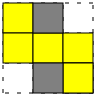

In [4]:
grid = [[0,1,0],
        [0,0,0],
        [0,1,0]]
solution = solve_maze(grid, 6)
draw_solution(grid, solution)

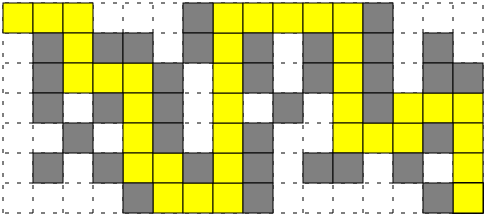

In [5]:
t_max = 40
grid = [[0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0],
        [0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0],
        [0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,1],
        [0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0],
        [0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0],
        [0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,0],
        [0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0]]
solution = solve_maze(grid, t_max)
draw_solution(grid, solution)